**LIBRARIES AND SETTINGS (PART 1)**

In [ ]:
# LIBRARIES
import os
import re
import time
import requests
import json
import folium
import fnmatch
import numpy as np
import pandas as pd
from pandas import json_normalize
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.express as px

# IGNORE WARNINGS
import warnings
warnings.filterwarnings("ignore")

# GET CURRENT WORKING DIRECTORY
print(os.getcwd())


---
---

**DATA IMPORT / ENRICH**

In [43]:
# READ CSV-FILES
df_imdb = pd.read_csv('IMDB.csv', sep=';', encoding='utf-8')
df_financial = pd.read_csv('BoxOffice.csv', sep=';', encoding='utf-8')

# CLEAN DATA
df_imdb['title'] = df_imdb['title'].str.strip().str.lower()
df_financial['title'] = df_financial['title'].str.strip().str.lower()

# MERGE DATA
df = pd.merge(df_imdb, df_financial, on='title')

# PRINT DATA
print("\nMERGED DATA:")
print(df.head())

# SAVE DATA
df.to_csv('IMDB_Merged_Movies.csv', sep=';', index=False, encoding='utf-8')



MERGED DATA:
                                           title  \
0                                  the godfather   
1                                the dark knight   
2                               schindler's list   
3  the lord of the rings: the return of the king   
4                                   pulp fiction   

                              genres  runtime_(mins) age_rating  \
0                       Crime, Drama             175         16   
1     Action, Crime, Drama, Thriller             152         16   
2          Biography, Drama, History             195         12   
3  Action, Adventure, Drama, Fantasy             201         12   
4                       Crime, Drama             154         16   

               director movie_rating  votes_count worldwide_lifetime_gross  \
0  Francis Ford Coppola          9,2      2070969             $250,342,198   
1     Christopher Nolan          9,0      2950798           $1,009,053,678   
2      Steven Spielberg          9,0

**COUNT / IDENTIFY DUPLICATED VALUES (IF ANY)**

In [44]:
# COUNT DUPLICATED VALUES
print(df.duplicated().sum())

# IDENTIFY ROWS WITH DUPLICATED VALUES
df[df[['title','genres','runtime_(mins)','age_rating','director','movie_rating','votes_count','worldwide_lifetime_gross','domestic_lifetime_gross','foreign_lifetime_gross','release_year']].duplicated()]

0


,title,genres,runtime_(mins),age_rating,director,movie_rating,votes_count,worldwide_lifetime_gross,domestic_lifetime_gross,foreign_lifetime_gross,release_year


**COUNT / IDENTIFY MISSING VALUES (IF ANY)**

In [45]:
# COUNT MISSING VALUES
print(pd.isna(df).sum())

# IDENTIFY ROWS WITH MISSING VALUES
df[df.isna().any(axis=1)].head()

title                       0
genres                      0
runtime_(mins)              0
age_rating                  0
director                    0
movie_rating                0
votes_count                 0
worldwide_lifetime_gross    0
domestic_lifetime_gross     0
foreign_lifetime_gross      0
release_year                4
dtype: int64


,title,genres,runtime_(mins),age_rating,director,movie_rating,votes_count,worldwide_lifetime_gross,domestic_lifetime_gross,foreign_lifetime_gross,release_year
0,the godfather,"Crime, Drama",175,16,Francis Ford Coppola,"9,2",2070969,"$250,342,198","$136,381,073",45.5%,NaN
45,gone with the wind,"Drama, Romance, War",238,12,Victor Fleming,"8,2",340258,"$402,382,193","$200,882,193",50.1%,NaN
69,the exorcist,Horror,122,16,William Friedkin,"8,1",468436,"$430,872,776","$233,005,644",45.9%,NaN
74,jaws,"Adventure, Drama, Thriller",124,16,Steven Spielberg,"8,1",680207,"$477,220,580","$266,567,580",44.1%,NaN


**DROP ROWS WITH MISSING VALUES**

In [46]:
# DROP MISSING VALUES
print(df.shape)
df = df.dropna()

# DROP DUPLICATED VALUES
print(df.shape)

(84, 11)
(80, 11)


**COUNT / DATA TYPE**

In [47]:
# REMOVE SPECIAL CHARACTERS
df['worldwide_lifetime_gross'] = df['worldwide_lifetime_gross'].replace({'\$': '', ',': ''}, regex=True).astype('int64')
df['domestic_lifetime_gross'] = df['domestic_lifetime_gross'].replace({'\$': '', ',': ''}, regex=True).astype('int64')
df['foreign_lifetime_gross'] = df['foreign_lifetime_gross'].replace({'%': '', ',': ''}, regex=True).astype('float64')/100
df['movie_rating'] = df['movie_rating'].str.replace(',', '.').astype('float64')

# CHANGE DATA TYPES
df['age_rating'] = df['age_rating'].astype('int64')
df['release_year'] = df['release_year'].astype('int64')

# DIMENSION (ROWS, COLUMNS)
print('Dimension:', df.shape)
print('Number of rows:', df.shape[0])
print('Number of columns:', df.shape[1])

# GET DATA TYPES
df.dtypes

Dimension: (80, 11)
Number of rows: 80
Number of columns: 11


title                        object
genres                       object
runtime_(mins)                int64
age_rating                    int64
director                     object
movie_rating                float64
votes_count                   int64
worldwide_lifetime_gross      int64
domestic_lifetime_gross       int64
foreign_lifetime_gross      float64
release_year                  int64
dtype: object

In [48]:
print (df.head())

                                               title  \
1                                    the dark knight   
2                                   schindler's list   
3      the lord of the rings: the return of the king   
4                                       pulp fiction   
5  the lord of the rings: the fellowship of the ring   

                              genres  runtime_(mins)  age_rating  \
1     Action, Crime, Drama, Thriller             152          16   
2          Biography, Drama, History             195          12   
3  Action, Adventure, Drama, Fantasy             201          12   
4                       Crime, Drama             154          16   
5  Action, Adventure, Drama, Fantasy             178          12   

            director  movie_rating  votes_count  worldwide_lifetime_gross  \
1  Christopher Nolan           9.0      2950798                1009053678   
2   Steven Spielberg           9.0      1488804                 322161245   
3      Peter Jackson   

---
---

<U>**EXPLORATORY DATA ANALYSIS (EDA): RICH NON-GRAPHICAL / GRAPHICAL**</U>

***DISTRIBUTION: DIRECTORS WITH THE MOST MOVIES***

In [49]:
df['director'].value_counts().head(10) 

director
Christopher Nolan    5
Steven Spielberg     5
Peter Jackson        3
Quentin Tarantino    3
Martin Scorsese      3
Pete Docter          3
Robert Zemeckis      2
Ridley Scott         2
Roger Allers         2
Andrew Stanton       2
Name: count, dtype: int64

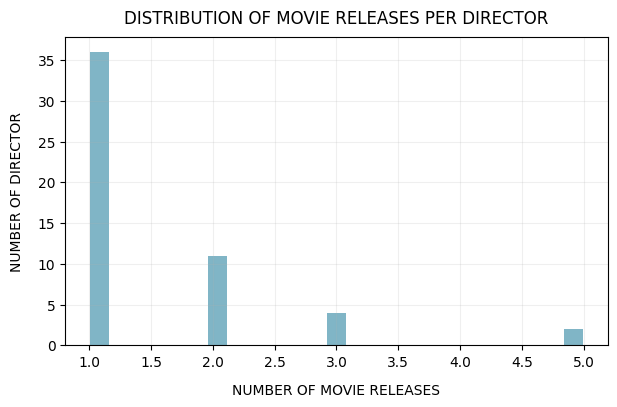

In [50]:

# PLOT HISTOGRAM
fig = plt.figure( figsize=(7,4))

plt.xticks(fontsize=14, rotation=0)
plt.yticks(fontsize=14, rotation=0)

n, bins, patches = plt.hist(x=df['director'].value_counts(), 
                            bins=25, 
                            color='#026c8e',
                            alpha=0.5, 
                            rwidth=0.95
                   )
plt.grid(True)
plt.ticklabel_format(style='plain')
plt.grid(alpha=0.2)

# SET LABELS
plt.title('DISTRIBUTION OF MOVIE RELEASES PER DIRECTOR', fontsize=12, pad=10)
plt.xlabel('NUMBER OF MOVIE RELEASES', fontsize=10, labelpad=10)
plt.ylabel('NUMBER OF DIRECTOR', fontsize=10, labelpad=10)

# SET FONT SIZE OF LABELS
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)

plt.show()

***DISTRIBUTION: MOVIES BY RELEASE YEAR***

In [51]:
df['release_year'].value_counts().head(10) 

release_year
2019    6
2010    5
1999    4
2014    4
2017    4
1991    4
2008    3
2018    3
2015    3
2012    3
Name: count, dtype: int64

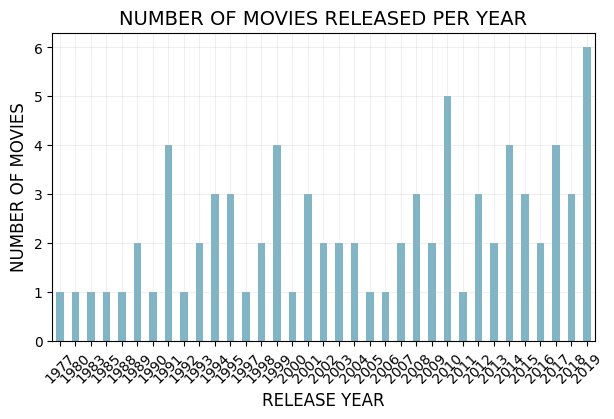

In [52]:
# MOVIE RELEASES BY YEAR
release_year_counts = df['release_year'].value_counts().sort_index()

# PLOT BAR CHART
fig = plt.figure(figsize=(7, 4))

release_year_counts.plot(kind='bar', color='#026c8e', alpha=0.5)
plt.grid(True)
plt.grid(alpha=0.2)

# SET LABELS
plt.title('NUMBER OF MOVIES RELEASED PER YEAR', fontsize=14)
plt.xlabel('RELEASE YEAR', fontsize=12)
plt.ylabel('NUMBER OF MOVIES', fontsize=12)

# SET FONT SIZE OF LABELS
plt.xticks(fontsize=10, rotation=45)
plt.yticks(fontsize=10)

plt.show()


**CREATE NEW VARIABLE (CATEGORIAL / V1)**

In [53]:
# DEFINE LABLES
labels_price = ['1950s', '1960s', '1970s', '1980s', '1990s', '2000s', '2010s']

# CONVERT RELEASE_YEAR TO INTEGER WITH ERROR HANDLING
if 'release_year' in df.columns:
    df['release_year'] = df['release_year'].astype(int)

# CREATE CATEGORIES 
df["year_cat2"] = pd.cut(df['release_year'], bins=[ 1950, 1960, 1970, 1980, 1990, 2000, 2010, 2020],labels=labels_price)

# SHOW CATEGORIES
print(df[['release_year', 'year_cat2']].head(10))


    release_year year_cat2
1           2008     2000s
2           1993     1990s
3           2003     2000s
4           1994     1990s
5           2001     2000s
6           1994     1990s
7           2010     2000s
8           1980     1970s
9           2002     2000s
10          2019     2010s


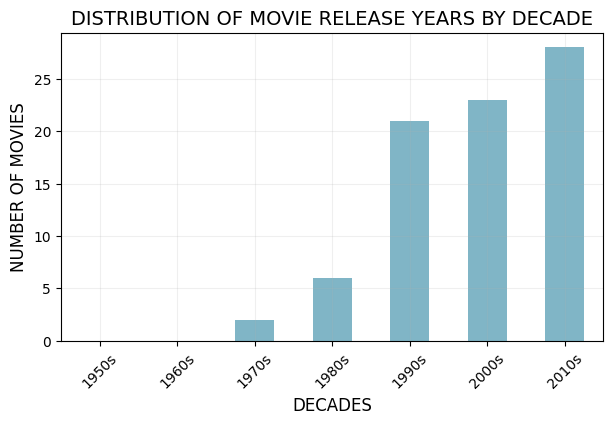

In [54]:
# DISPLAY BAR CHART
fig = plt.figure(figsize=(7,4))

# COUNT CATEGORIES
category_counts = df['year_cat2'].value_counts().sort_index()

# PLOT BAR CHART
category_counts.plot(kind='bar', color='#026c8e', alpha=0.5)
plt.grid(True)
plt.grid(alpha=0.2)

# SET LABELS
plt.title('DISTRIBUTION OF MOVIE RELEASE YEARS BY DECADE', fontsize=14)
plt.xlabel('DECADES', fontsize=12)
plt.ylabel('NUMBER OF MOVIES', fontsize=12)
plt.xticks(fontsize=10, rotation=45)
plt.yticks(fontsize=10)

plt.show()


**CREATE NEW VARIABLE (CATEGORIAL / V2)**

In [55]:
# DEFINE LABELS
labels = ['1970 - 1979', '1980 - 1989', '1990 - 1999', '2000 - 2009', '2010 - 2019']

# CONVERT RELEASE_YEAR TO INTEGER WITH ERROR HANDLING
if 'release_year' in df.columns:
    df['release_year'] = df['release_year'].astype(int)

# CREATE CATEGORIES
df["year_cat"] = pd.cut(df['release_year'], bins=[1970, 1980, 1990, 2000, 2010, 2020], labels=labels)

# SHOW CATEGORIES
print(df[['release_year', 'year_cat']].head(10))


    release_year     year_cat
1           2008  2000 - 2009
2           1993  1990 - 1999
3           2003  2000 - 2009
4           1994  1990 - 1999
5           2001  2000 - 2009
6           1994  1990 - 1999
7           2010  2000 - 2009
8           1980  1970 - 1979
9           2002  2000 - 2009
10          2019  2010 - 2019


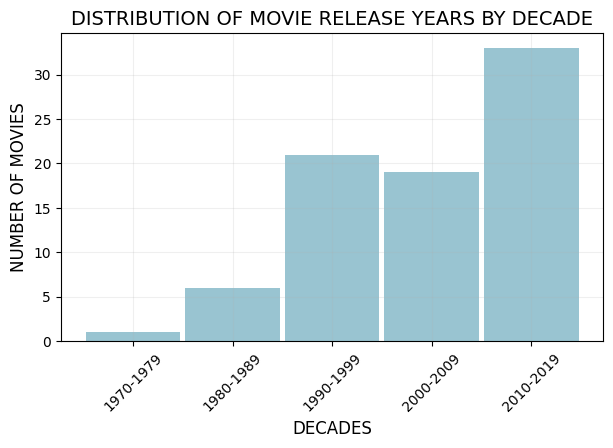

In [56]:
# DISPLAY HISTOGRAM
fig = plt.figure(figsize=(7, 4))

# PLOT HISTOGRAM
plt.hist(df['release_year'], bins=[1970, 1980, 1990, 2000, 2010, 2020], color='#026c8e', alpha=0.4, rwidth=0.95)

# SET GRID AND FORMAT
plt.grid(True)
plt.grid(alpha=0.2)

# SET LABELS
plt.title('DISTRIBUTION OF MOVIE RELEASE YEARS BY DECADE', fontsize=14)
plt.xlabel('DECADES', fontsize=12)
plt.ylabel('NUMBER OF MOVIES', fontsize=12)
plt.xticks([1975, 1985, 1995, 2005, 2015], ['1970-1979', '1980-1989', '1990-1999', '2000-2009', '2010-2019'], fontsize=10, rotation=45)
plt.yticks(fontsize=10)

plt.show()


<U>**STATISTICS**</U>

***SUMMARY STATISTICS OF NUMERIC VARIABLES***

In [57]:
df.describe().round(2)

,runtime_(mins),age_rating,movie_rating,votes_count,worldwide_lifetime_gross,domestic_lifetime_gross,foreign_lifetime_gross,release_year
count,80.00,80.00,80.00,80.00,8.000000e+01,8.000000e+01,80.00,80.00
mean,133.07,9.93,8.30,1162905.56,6.119853e+08,2.443303e+08,0.58,2004.49
std,29.54,5.82,0.29,562810.51,4.418680e+08,1.504762e+08,0.09,10.81
min,81.00,0.00,7.90,40297.00,1.874368e+08,5.667199e+07,0.24,1977.00
25%,114.75,6.00,8.10,749621.25,3.202932e+08,1.380254e+08,0.52,1995.00
50%,130.50,12.00,8.20,1121958.50,4.731301e+08,2.066546e+08,0.59,2006.50
75%,151.25,13.00,8.50,1485854.25,7.852092e+08,3.221429e+08,0.64,2014.00
max,201.00,16.00,9.00,2950798.00,2.799439e+09,8.583730e+08,0.74,2019.00


***QUANTILES VALUES***

In [58]:
df[['release_year', 'runtime_(mins)']].quantile(q=[0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95]).round(2)

,release_year,runtime_(mins)
0.05,1987.85,88.00
0.10,1990.90,94.70
0.25,1995.00,114.75
0.50,2006.50,130.50
0.75,2014.00,151.25
0.90,2018.00,178.10
0.95,2019.00,181.40


---
---

**GEOGRAPHICAL DATA**

In [59]:

# MOVIES
csv_datas = ["movie1 (Avengers).csv", "movie2 (LionKing).csv", "movie3 (Joker).csv",
             "movie4 (Aladdin).csv", "movie5 (DowntonAbbey).csv", "movie6 (KnivesOut).csv"]
df_list = []

# LOAD DATA
for data in csv_datas:
    df_temp = pd.read_csv(data, sep=';')
    df_temp['Gross'] = df_temp['Gross'].str.replace(
        '$', '', regex=False).astype(float)
    df_list.append(df_temp)

# CONCAT DATA
df = pd.concat(df_list, ignore_index=True)

# GROUP DATA
df_grouped = df.groupby('Area')['Gross'].agg(['mean']).reset_index()
df_grouped['mean_numeric'] = df_grouped['mean'].round()
df_grouped['mean'] = df_grouped['mean_numeric'].apply(
    lambda x: f"{x:,.0f}".replace(",", "'"))

# PRINT DATA: ALL COUNTRIES
print("AGGREGATED MOVIE DATA BY COUNTRY:")
print(df_grouped[['Area', 'mean']])

# PRINT DATA: TOP 5 COUNTRIES (SORTED BY NUMERIC VALUE)
print("\n\nTOP 5 COUNTRIES BY AVERAGE GROSS REVENUE:")
df_sorted = df_grouped.sort_values(by='mean_numeric', ascending=False)
top_5_countries = df_sorted.head(5)
print(top_5_countries[['Area', 'mean']])

# GEOGRAPHICAL DATA
fig = px.choropleth(
    df_grouped,
    locations="Area",
    locationmode="country names",
    color="mean_numeric",
    title="GEOGRAPHICAL DISTRIBUTION OF AVERAGE MOVIE GROSS REVENUE (EUROPE)",
    color_continuous_scale="Blues",
    scope='europe'
)
fig.show()

AGGREGATED MOVIE DATA BY COUNTRY:
                     Area        mean
0                 Austria   4'575'470
1                 Bahrain     106'048
2                 Belgium   6'430'234
3                Bulgaria     599'830
4                 Croatia     711'626
5                  Cyprus      29'957
6          Czech Republic   2'412'210
7                 Denmark   5'198'657
8                   Egypt     168'454
9                 Estonia     183'454
10                Finland   3'315'422
11                 France  36'576'286
12                Germany  34'241'525
13                 Greece   1'612'745
14                Hungary   1'931'317
15                Iceland     406'744
16                 Israel     617'522
17                  Italy  23'107'293
18                 Jordan      76'998
19                 Kuwait     427'631
20                 Latvia      72'973
21                Lebanon      85'910
22              Lithuania     503'902
23            Netherlands  13'316'856
24              

---
---

### Jupyter notebook --footer info--

In [139]:
import os
import platform
import socket
from platform import python_version
from datetime import datetime

print('-----------------------------------')
print(os.name.upper())
print(platform.system(), '|', platform.release())
print('Datetime:', datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
print('Python Version:', python_version())
print('-----------------------------------')

-----------------------------------
POSIX
Linux | 6.5.0-1025-azure
Datetime: 2025-01-09 08:57:04
Python Version: 3.11.10
-----------------------------------


###